In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *
from local.callback.schedule import *
import torchaudio
from fastprogress import progress_bar as pb
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV

In [ ]:
from numba import njit, prange
import numpy as np

@njit
def generate_kernels(input_length, num_kernels, candidate_lengths=np.array((7, 9, 11)), stride=5):
    # initialise kernel parameters
    strides = np.ones(num_kernels, dtype = np.int32) * stride
    weights = np.zeros((num_kernels, candidate_lengths.max())) # see note
    lengths = np.zeros(num_kernels, dtype = np.int32) # see note
    biases = np.zeros(num_kernels)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)
    # note: only the first *lengths[i]* values of *weights[i]* are used
    for i in range(num_kernels):
        length = np.random.choice(candidate_lengths)
        _weights = np.random.normal(0, 1, length)
        bias = np.random.uniform(-1, 1)
        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) // (length - 1)))
        padding = ((length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        weights[i, :length] = _weights - _weights.mean()
        lengths[i], biases[i], dilations[i], paddings[i] = length, bias, dilation, padding
    return weights, lengths, biases, dilations, paddings, strides

In [ ]:
@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding, stride):
    # zero padding
    if padding > 0:
        _input_length = len(X)
        _X = np.zeros(_input_length + (2 * padding))
        _X[padding:(padding + _input_length)] = X
        X = _X
    input_length = len(X)
    output_length = (input_length - ((length - 1) * dilation))//stride
    _ppv = 0 # "proportion of positive values"
    _max = np.NINF
    for i in range(output_length):
        _sum = bias
        for j in range(length):
            _sum += weights[j] * X[i*stride + (j * dilation)]
        if _sum > 0:
            _ppv += 1
        if _sum > _max:
            _max = _sum
    return _ppv / output_length, _max

In [ ]:
@njit(parallel = True, fastmath = True)
def apply_kernels(X, kernels):
    weights, lengths, biases, dilations, paddings, strides = kernels
    num_examples = len(X)
    num_kernels = len(weights)
    # initialise output
    _X = np.zeros((num_examples, num_kernels * 2)) # 2 features per kernel
    for i in prange(num_examples):
        for j in range(num_kernels):
            _X[i, (j * 2):((j * 2) + 2)] = \
            apply_kernel(X[i], weights[j][:lengths[j]], lengths[j], biases[j], dilations[j], paddings[j], strides[j])
    return _X

In [ ]:
p10speakers = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)

In [ ]:
files_10

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files_10)

In [ ]:
CLIP_LENGTH = 2

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
sigs, labels = [],[]
cropper = CropSignal(1000*CLIP_LENGTH, pad_mode='repeat')
remove_silence = RemoveSilence()
for i in pb(range(len(files_10))):
    sigs.append(cropper(remove_silence(oa(i))).sig)
    labels.append(labeler(files_10[i]))

In [ ]:
len(sigs), len(labels)

(3842, 3842)

In [ ]:
#d = list(zip(sigs, labels))

In [ ]:
#d[0]

In [ ]:
#train, valid = train_test_split()

In [ ]:
train_size = int(3842*.8)
train_idxs = torch.randperm(3842)[:train_size]
valid_idxs = [i for i in range(3842) if i not in train_idxs]

In [ ]:
assert len(train_idxs) + len(valid_idxs) == len(sigs)

In [ ]:
x_train = [sigs[idx].squeeze(0).numpy() for idx in train_idxs]
y_train = [labels[idx] for idx in train_idxs]
x_valid = [sigs[idx].squeeze(0).numpy() for idx in valid_idxs]
y_valid = [labels[idx] for idx in valid_idxs]

In [ ]:
list(map(len, (x_train, y_train, x_valid, y_valid)))

[3073, 3073, 769, 769]

In [ ]:
np_x_train = np.stack(x_train).astype(np.float64)
np_x_valid = np.stack(x_valid).astype(np.float64)
np_x_train.shape, np_x_valid.shape

((3073, 32000), (769, 32000))

In [ ]:
o2i_f = lambda x: 5*(x[0]=='m') + int(x[-1]) - 1

In [ ]:
np_y_train = np.array(list(map(o2i_f, y_train)))
np_y_valid = np.array(list(map(o2i_f, y_valid)))

In [ ]:
np_y_train

array([9, 0, 2, ..., 3, 2, 8])

In [ ]:
np_x_train.shape, np_y_train.shape, np_x_valid.shape, np_y_valid.shape

((3073, 32000), (3073,), (769, 32000), (769,))

In [ ]:
np_x_train.mean()

-4.516795804203429e-05

### Normalize the training data

In [ ]:
np_x_train = (np_x_train - np_x_train.mean(axis = 1, keepdims = True)) / (np_x_train.std(axis = 1, keepdims = True) + 1e-8)
np_x_valid = (np_x_valid - np_x_valid.mean(axis = 1, keepdims = True)) / (np_x_valid.std(axis = 1, keepdims = True) + 1e-8)

In [ ]:
np_x_train.mean(), np_x_train.std()

(-2.4942986534370586e-19, 0.9999995602214256)

In [ ]:
np_x_train.dtype

dtype('float64')

In [ ]:
candidate_lengths = np.array((7,9,11))
stride = 3

In [ ]:
def timing_test(runs, candidate_lengths, stride, num_kernels, seq_length, show_progress=True):
    times, scores = [],[]
    for i in range(runs):
        kernels = generate_kernels(seq_length, num_kernels, candidate_lengths, stride)
        start = time.time()
        x_train_tfm = apply_kernels(np_x_train, kernels)
        x_valid_tfm = apply_kernels(np_x_valid, kernels)
        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
        classifier.fit(x_train_tfm, np_y_train)
        score = classifier.score(x_valid_tfm, np_y_valid)
        t = time.time()-start
        scores.append(score)
        times.append(t)
        if(show_progress): print("Finished Run", i+1, "Score:", round(score, 3), "Time:", round(t,3))
    return times, scores

In [ ]:
def test_kernel_sizes(runs=10):
    score_list = []
    for k in range(3,100,2):
        
        times, scores = timing_test(runs, np.array((k,)), stride=5, num_kernels=1, seq_length=32000, show_progress=False)
        score = round(sum(scores)/len(scores), 3)
        mn = round(min(scores), 3)
        mx = round(max(scores), 3)
        print("Kernel Size:", k, "Score:", score, "Min:", mn, "Max:",mx)
        score_list.append(score)
    return score_list

In [ ]:
test_kernel_sizes(runs = 50)

Kernel Size: 3 Score: 0.238 Min: 0.144 Max: 0.325
Kernel Size: 5 Score: 0.225 Min: 0.163 Max: 0.299
Kernel Size: 7 Score: 0.23 Min: 0.127 Max: 0.311
Kernel Size: 9 Score: 0.224 Min: 0.153 Max: 0.306
Kernel Size: 11 Score: 0.208 Min: 0.14 Max: 0.313
Kernel Size: 13 Score: 0.218 Min: 0.127 Max: 0.316
Kernel Size: 15 Score: 0.21 Min: 0.137 Max: 0.283
Kernel Size: 17 Score: 0.218 Min: 0.137 Max: 0.316
Kernel Size: 19 Score: 0.209 Min: 0.133 Max: 0.303
Kernel Size: 21 Score: 0.203 Min: 0.126 Max: 0.283
Kernel Size: 23 Score: 0.195 Min: 0.14 Max: 0.286
Kernel Size: 25 Score: 0.203 Min: 0.129 Max: 0.315
Kernel Size: 27 Score: 0.205 Min: 0.127 Max: 0.312
Kernel Size: 29 Score: 0.207 Min: 0.13 Max: 0.298
Kernel Size: 31 Score: 0.197 Min: 0.13 Max: 0.278
Kernel Size: 33 Score: 0.203 Min: 0.13 Max: 0.293
Kernel Size: 35 Score: 0.195 Min: 0.131 Max: 0.265
Kernel Size: 37 Score: 0.193 Min: 0.117 Max: 0.289
Kernel Size: 39 Score: 0.202 Min: 0.112 Max: 0.341
Kernel Size: 41 Score: 0.203 Min: 0.12 Max

[0.238,
 0.225,
 0.23,
 0.224,
 0.208,
 0.218,
 0.21,
 0.218,
 0.209,
 0.203,
 0.195,
 0.203,
 0.205,
 0.207,
 0.197,
 0.203,
 0.195,
 0.193,
 0.202,
 0.203,
 0.19,
 0.202,
 0.191,
 0.206,
 0.198,
 0.184,
 0.193,
 0.194,
 0.191,
 0.192,
 0.186,
 0.192,
 0.177,
 0.194,
 0.193,
 0.189,
 0.18,
 0.186,
 0.197,
 0.19,
 0.195,
 0.186,
 0.188,
 0.176,
 0.185,
 0.184,
 0.18,
 0.181,
 0.185]

In [ ]:
scores = _

Text(0, 0.5, 'Single Filter accuracy')

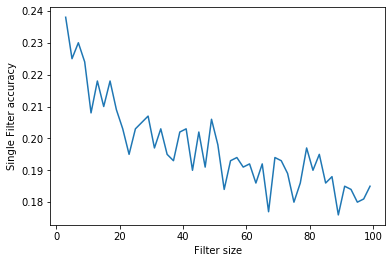

In [ ]:
plt.plot(np.arange(3,100,2), scores)
plt.xlabel("Filter size")
plt.ylabel("Single Filter accuracy")

In [ ]:
a

KeyboardInterrupt: 

In [ ]:
%%time 
#test time with a fraction of data
x_small_tfm = apply_kernels(np_x_train[0:100], kernels)

CPU times: user 2 s, sys: 8 ms, total: 2 s
Wall time: 303 ms


In [ ]:
timing_test(5, np.array((7,9,11)), stride=5, num_kernels=200, seq_length=16000)

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 7       | .85     |  4:30 |
| {7,9,11}         | 5       | .899    |  5:20  |
| {7,9,11}         | 3       | .903    |  8:15  |
|{800,1000,1200}   | 400     | .46     |  3:43  |


**Silence removed results 10000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .979     |  5:08 |
| {7,9,11}         | 5       | .976     |  5:10 |
| {7,9,11}         | 5       | .980     |  5:26 |


**Silence removed results 2000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}          | 5       | .972     |  1:10 |
| {7,9,11}         | 5       | .979     |  1:03 |
| {7,9,11}         | 5       | .976     |  1:01 |

**Silence removed results 1000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .974     |  0:31 |
| {7,9,11}         | 5       | .974     |  0:31 |
| {7,9,11}         | 5       | .966     |  0:31 |

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .949     |  0:06 |
| {7,9,11}         | 5       | .950     |  0:06 |
| {7,9,11}         | 5       | .934     |  0:06|

## messing with strides with fewer kernels

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 1       | .942     |  0:30 |
| {7,9,11}         | 1       | .954     |  0:28 |
| {7,9,11}         | 1       | .950     |  0:28|

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .960     |  0:10 |
| {7,9,11}         | 3       | .948     |  0:10 |
| {7,9,11}         | 3       | .954     |  0:10 |

## Up clip length to 2 seconds

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .987     |  0:15 |
| {7,9,11}         | 5       | .980     |  0:13 |
| {7,9,11}         | 5       | .986     |  0:13 |

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .986     |  0:20 |
| {7,9,11}         | 3       | .986     |  0:20 |
| {7,9,11}         | 3       | .990     |  0:20 |

**Silence removed results 1000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .992     |  1:40 |
| {7,9,11}         | 3       | .992     |  1:40 |
| {7,9,11}         | 3       | .992     |  1:40 |

In [ ]:
timing_test(3, np.array((7,9,11)), stride=3, num_kernels=100, seq_length=32000)

Finished Run 1 0.971 10.206
Finished Run 2 0.969 10.016
Finished Run 3 0.966 9.832


([10.206007480621338, 10.015744686126709, 9.83171796798706],
 [0.9713914174252276, 0.9687906371911573, 0.9661898569570871])

## Check impact of the kernel size options, do we really need to choose from 3?

In [ ]:
timing_test(5, np.array((7,)), stride=3, num_kernels=1000, seq_length=32000)

Finished Run 1 Score: 0.992 Time: 125.668
Finished Run 2 Score: 0.992 Time: 125.973


In [ ]:
timing_test(5, np.array((9,)), stride=3, num_kernels=1000, seq_length=32000)


In [ ]:
timing_test(5, np.array((11,)), stride=3, num_kernels=1000, seq_length=32000)

In [ ]:
timing_test(5, np.array((7,9,11)), stride=3, num_kernels=1000, seq_length=32000)

## What is the predictive power of a single kernel?

In [ ]:
times, scores = timing_test(100, np.array((7,9,11)), stride=5, num_kernels=1, seq_length=32000)

Finished Run 1 Score: 0.319 Time: 0.089
Finished Run 2 Score: 0.224 Time: 0.16
Finished Run 3 Score: 0.222 Time: 0.095
Finished Run 4 Score: 0.212 Time: 0.15
Finished Run 5 Score: 0.168 Time: 0.098
Finished Run 6 Score: 0.218 Time: 0.159
Finished Run 7 Score: 0.203 Time: 0.159
Finished Run 8 Score: 0.259 Time: 0.134
Finished Run 9 Score: 0.187 Time: 0.114
Finished Run 10 Score: 0.176 Time: 0.199
Finished Run 11 Score: 0.191 Time: 0.173
Finished Run 12 Score: 0.282 Time: 0.112
Finished Run 13 Score: 0.164 Time: 0.119
Finished Run 14 Score: 0.209 Time: 0.171
Finished Run 15 Score: 0.169 Time: 0.161
Finished Run 16 Score: 0.198 Time: 0.162
Finished Run 17 Score: 0.208 Time: 0.165
Finished Run 18 Score: 0.222 Time: 0.153
Finished Run 19 Score: 0.246 Time: 0.189
Finished Run 20 Score: 0.177 Time: 0.168
Finished Run 21 Score: 0.286 Time: 0.167
Finished Run 22 Score: 0.251 Time: 0.098
Finished Run 23 Score: 0.242 Time: 0.149
Finished Run 24 Score: 0.222 Time: 0.114
Finished Run 25 Score: 0.15

In [ ]:
sum(scores)/len(scores)

0.20929778933680107

## Let's see what this is really doing 

In [ ]:
seq_length = 32000
kernels = generate_kernels(32000, num_kernels=1, candidate_lengths=np.array((7,)), stride=1)


In [ ]:
#return weights, lengths, biases, dilations, paddings, strides
kernels

(array([[-0.8703073 , -0.21376067,  1.7579694 , -1.17941855, -0.01218891,
          0.32218775,  0.19551828]]),
 array([7], dtype=int32),
 array([-0.34924512]),
 array([2783], dtype=int32),
 array([8350], dtype=int32),
 array([1]))

In [ ]:
type(np_x_train)

numpy.ndarray

In [ ]:
x_train_tfm_single = apply_kernels(np.expand_dims(np_x_train[0], 0),kernels)

In [ ]:
x_train_tfm_single

array([[ 0.4112243, 12.2445997]])

In [ ]:

x_train_tfm_all = apply_kernels(np_x_train,kernels)

In [ ]:
x_train_tfm_all.shape

(3073, 2)

In [ ]:
# min and max ppv
x_train_tfm_all[:,0].min(), x_train_tfm_all[:,0].max()

(0.1357415161552403, 0.43981626148365727)

In [ ]:
# min and max maxpool
x_train_tfm_all[:,1].min(), x_train_tfm_all[:,1].max()

(7.565008650099326, 44.96004563476433)